In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.stats import expon

C:\Users\slm\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
class Bandit:
    def __init__(self, num_arms, beta_vals=None):
        # Set the random seed for reproducibility
        np.random.seed(seed=7)
        # Store the number of arms
        self.num_arms = num_arms
        # Define a small positive constant to avoid division by zero errors
        epsilon = 1e-6
        # Initialize the beta values for each arm
        if beta_vals is None:
            # If no beta values are provided, sample them randomly from a uniform distribution on [epsilon, 1]
            self.beta_vals = np.random.uniform(epsilon, 1, num_arms)
        else:
            # If beta values are provided
            self.beta_vals = beta_vals
        # Initialize arrays to store the total reward and number of pulls for each arm
        self.S = np.zeros(num_arms)
        self.F = np.zeros(num_arms)
    
    def pull_arm(self, arm_index):
        # Sample a reward from an exponential distribution with rate beta_vals[arm_index]
        reward = np.random.exponential(self.beta_vals[arm_index])
        # Return the sampled reward
        return reward

In [3]:
def thompson_sampling(num_arms, num_episodes, beta=None):
    bandit = Bandit(num_arms, beta)
    theta = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    for t in range(1, num_episodes+1):
        for i in range(num_arms):
            #Theta(i) sampled from Beta(S[i], F[i])
            theta[i] = np.random.beta(bandit.S[i] + 1, bandit.F[i] + 1)

        action = np.argmax(theta)
        reward_probability = bandit.pull_arm(action)

        reward_probability = min(max(reward_probability, 0), 1)
        r_t = np.random.binomial(1, reward_probability)

        if r_t == 1:
            bandit.S[action] += 1
        else:
            bandit.F[action] += 1

        sequence_pulls.append(action)
        reward_round.append(reward_probability)

    return sequence_pulls, reward_round

In [4]:
def thompson_sampling_with_budget(num_arms, num_episodes, budget, beta=None):
    bandit = Bandit(num_arms, beta)
    theta = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    for t in range(1, num_episodes+1):
        if t < budget+1:
            # Exploration phase: Randomly select arms without using Thompson Sampling
            action = np.random.randint(0, num_arms)
        else:
            for i in range(num_arms):
                theta[i] = np.random.beta(bandit.S[i] + 1, bandit.F[i] + 1)
            action = np.argmax(theta)
        reward_probability = bandit.pull_arm(action)

        reward_probability = min(max(reward_probability, 0), 1)
        r_t = np.random.binomial(1, reward_probability)

        if r_t == 1:
            bandit.S[action] += 1
        else:
            bandit.F[action] += 1

        sequence_pulls.append(action)
        reward_round.append(reward_probability)

    return sequence_pulls, reward_round

In [69]:
'''
Old KL function, works %2.2 slower
def KL(X, Y):
    f = lambda x: X.pdf(x) * (np.log(X.pdf(x)/Y.pdf(x)))
    return quad(f, -np.inf, np.inf)[0]
'''
def KL(X, Y):
    # Define the integrand function for the KL divergence
    f = lambda x: -X.pdf(x)*(Y.logpdf(x) - X.logpdf(x))
    # Compute the definite integral of the integrand from -inf to inf
    return quad(f, -np.inf, np.inf)[0]

def solve_X(mu, result):
    # Create an exponential distribution object with rate mu
    X = expon(scale=1/mu)
    # Define a function to find the root of
    def f(x):
        # Create an exponential distribution object with rate x
        Y = expon(scale=1/x)
        # Compute the difference between the KL divergence and the target result (result - kl = 0)
        return KL(X, Y) - result
    # Use fsolve to find the root of the function f
    x = fsolve(f, mu)
    return x[0]

def sample_theta(mu, n):
    # when n - 1 = 0, prevent divide by zero by setting result to 0 
    if n == 1: result = 0
    else:
        # Sample a random value y from a uniform distribution on [0, 1]
        y = np.random.uniform(0, 1)
        if y >= 0.5:
            # Compute the target result for KL(mu, x) using y (y>=1/2) and n
            result = np.log(1 / (2 * (1 - y))) / (n - 1)
        else:
            # Compute the target result for KL(mu, x) using y (y<1/2) and n
            result = np.log(1 / (2 * y)) / (n - 1)
    # Solve for x using the solve_X function
    x = solve_X(mu, result)
    return x

def exponential_thompson_sampling(num_arms, num_episodes, beta=None):
    # Create a bandit object with the given number of arms and beta values
    bandit = Bandit(num_arms, beta)
    # Initialize an array to store the theta values for each arm with 0s
    theta_values = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []
    
    # Loop over the episodes
    for t in range(1, num_episodes + 1):
        # Exploration: Play each arm once
        if t < num_arms + 1:
            # Select the current arm as the action
            action = t - 1
            # Pull the selected arm and observe the reward
            reward = bandit.pull_arm(action)
            # Update the total reward and number of pulls for the selected arm
            bandit.S[action] += reward
            bandit.F[action] += 1
        else:
            # Exploitation: Select the arm with the highest sampled theta valu
            for i in range(num_arms):
                # Compute the mean reward (mu_i) and number of pulls (n_i) for arm i
                mu_i = bandit.S[i] / bandit.F[i]
                n_i = bandit.F[i]
                # Sample θi(t) independently from P(̂μi(t), Ti(t))
                theta_values[i] = sample_theta(mu_i, n_i)
            print(theta_values)
            # Select the arm with the highest sampled theta value as the action
            action = np.argmax(theta_values)
            # Pull the selected arm and observe the reward
            reward = bandit.pull_arm(action)
            # Update the total reward and the number of pulls
            bandit.S[action] += reward
            bandit.F[action] += 1
        # Store the selected action and observed reward in the sequence arrays
        sequence_pulls.append(action)
        reward_round.append(reward)

    # Return the sequence of arm pulls and average rewards per arm
    return sequence_pulls, reward_round

In [3]:
_beta = [0.2, 0.3, 0.75, 0.8, 0.85, 0.9]
num_arms = 6
num_episodes = 30

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 3.243800780025824, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.9174414045817416, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.3668570856643212, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.266761882937572, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.0949338412026608, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 0.9605948009369021, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.6101741304280051, 0.9605948009369021, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.6101741304280051, 0.8264287277204285, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639

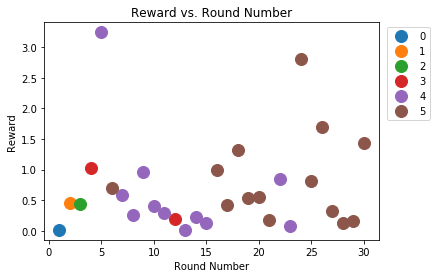

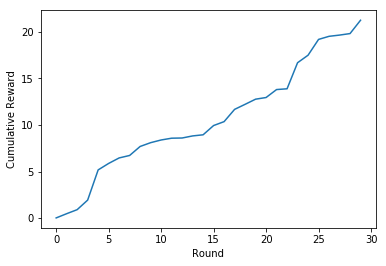

In [70]:
s6, r6 = exponential_thompson_sampling(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s6, r6)

In [4]:
def peef(num_arms, num_episodes, epsilon, beta=None):
    # Array of mean rewards from the previous round
    previous_mean_rewards = np.zeros(num_arms)
    # total pulls available
    totalPullsAvailable = num_episodes
    sequenceArmPulls = np.zeros(totalPullsAvailable)
    # Array of rewards for each round
    reward_round = np.zeros(totalPullsAvailable)
    round = 0
    G = 0
    
    # E.g. Arm 1 is in index 0, so index 0 has arm 1.
    availableArms = np.arange(1,num_arms+1)
    # number of arms pulled 
    numPulled = np.zeros(num_arms)
    numPasses = 0
    roundNum = 1
    # reward array for each arm
    reward_array = np.zeros(num_arms)
    rewards = 0
    numPasses = 0
    # mean rewards vector for this round
    current_meanRewards = np.zeros(num_arms)
    bandit = Bandit(num_arms, beta)
    # The l-split value
    l_split = (epsilon*totalPullsAvailable-1)/(epsilon*totalPullsAvailable-num_arms)
    #print(l_split)
    while len(availableArms)!=0:
        for i in range(num_arms):
            
            # i+1 represents the arm number because we are avoiding an arm value of 0.
            if i+1 in availableArms:
                if totalPullsAvailable>0:
                    action = i
                    #print("Round: ", roundNum, "Arm: ", action, current_meanRewards)
                    roundNum += 1
                    reward = bandit.pull_arm(action)
                    reward_round[round] = reward
                    # Rewards for each arm
                    reward_array[i] += reward
                    # total rewards
                    rewards += reward
                    current_meanRewards[i] = ((current_meanRewards[i]*numPulled[i]) + reward)/(numPulled[i] + 1)
                    sequenceArmPulls[round] = i+1
                    totalPullsAvailable -= 1
                    numPulled[i] += 1
                    round += 1
        numPasses += 1

        availableArms = []
        # How many arms we can pull based on the l_split algorithm
        numToPull = (num_arms) / pow(l_split, numPasses)
         
      # We create this copy arrray for the next while loop which will put -1 on the index 
      # we already inserted into the availableArms so that argmax will not continuously choose
      # the same number.
        copyArrayMean = np.zeros(num_arms)
        for i in range(num_arms):
            copyArrayMean[i] = current_meanRewards[i]
        # ----------------------------------------------------------------------------
        
        while numToPull>0 and num_arms-len(availableArms) is not None:
            curr_max = np.argmax(copyArrayMean)
            if curr_max+1 in availableArms and numToPull!=1:
                # Remove the value that is already in the availableArms array
                copyArrayMean[curr_max] = -1
            if copyArrayMean[np.argmax(copyArrayMean)]!=-1 and totalPullsAvailable>0 and numToPull!=1:   
                availableArms.append(np.argmax(copyArrayMean)+1)
                numToPull -= 1
            elif numToPull==1 and totalPullsAvailable>0:
                availableArms.append(np.argmax(copyArrayMean)+1)
                numToPull -= 1
            else:
                numToPull = 0
        #print(availableArms)
    return sequenceArmPulls, reward_round

In [5]:
def SOAAv(num_arms, num_episodes, factor, beta=None):
    num_total_pulls = 1
    sequence_pulls = []
    total_reward = 0
    pull_budget = num_episodes
    count_pull = np.zeros(num_arms)
    mean_reward_arm = np.zeros(num_arms)
    arms_available = np.arange(1, num_arms+1)
    total_arm = num_arms
    elimination_factor = factor
    reward_round = np.zeros(num_episodes)  # Initialize reward_round with zeros
    round_num = 0
    bandit = Bandit(num_arms, beta)

    while pull_budget >= 1 and len(arms_available) > 0:
        numPullsInPass = 0
        passAverageRatio = 0

        for i in range(num_arms):
            if (i+1) in arms_available and pull_budget >= 1:
                action = i
                reward = bandit.pull_arm(action)
                reward_round[round_num] = reward
                round_num += 1
                total_reward += reward
                count_pull[action] += 1
                mean_reward_arm[action] = ((mean_reward_arm[action]*count_pull[action]) + reward) / (count_pull[action])
                sequence_pulls.append(action)
                pull_budget -= 1
                num_total_pulls += 1
                passAverageRatio = passAverageRatio + reward
                numPullsInPass += 1

        if numPullsInPass > 0:
            passAverageRatio = passAverageRatio / numPullsInPass
            arms_available = [i+1 for i in range(total_arm) if mean_reward_arm[i] >= (1 + elimination_factor) * passAverageRatio]

    return sequence_pulls, reward_round

In [27]:
a=np.random.randint(0,5,1)
print(a)

[3]


In [38]:
class UCB:
    def __init__(self, num_arms):
        np.random.seed(seed=7)
        self.num_arms = num_arms
        self.Q = np.zeros(num_arms)  # Average reward obtained from each action
        self.N = np.zeros(num_arms)  # Number of times each action has been taken
        self.t = 0  # Time step

    def select_action(self):
        if self.t < self.num_arms:
            # Take each action once initially
            action = self.t
        else:
            # UCB formula to select action with the highest UCB value
            ucb_values = self.Q + np.sqrt(2 * np.log(self.t) / (self.N))
            action = np.argmax(ucb_values)

        self.t += 1
        return action

    def update(self, action, reward):
        # Update average reward and number of times the action has been taken
        self.N[action] += 1
        self.Q[action] = ((self.N[action] - 1) * self.Q[action] + reward) / self.N[action]

def UCB_algorithm(num_arms, num_episodes, beta=None):
    bandit = Bandit(num_arms, beta)
    ucb_agent = UCB(num_arms)
    sequence_pulls = []
    reward_round = []

    for t in range(num_episodes):
        action = ucb_agent.select_action()
        reward = bandit.pull_arm(action)
        ucb_agent.update(action, reward)

        sequence_pulls.append(action)
        reward_round.append(reward)

    return sequence_pulls, reward_round

In [44]:
class UCB0:
    def __init__(self, num_arms):
        np.random.seed(seed=7)
        self.num_arms = num_arms
        self.Q = np.zeros(num_arms)  # Average reward obtained from each action
        self.N = np.zeros(num_arms)  # Number of times each action has been taken
        self.t = 0  # Time step

    def select_action(self):
        if self.t < self.num_arms:
            # Take each action once initially
            
            r = np.random.randint(0,5,1)[0]
            while self.N[r] > 0:
                r = np.random.randint(0,5,1)[0]
            self.t += 1
            action = r
        else:
            # UCB formula to select action with the highest UCB value
            ucb_values = self.Q + np.sqrt(2 * np.log(self.t) / (self.N))
            action = np.argmax(ucb_values)

        self.t += 1
        return action

    def update(self, action, reward):
        # Update average reward and number of times the action has been taken
        self.N[action] += 1
        self.Q[action] = ((self.N[action] - 1) * self.Q[action] + reward) / self.N[action]

def UCB_algorithm0(num_arms, num_episodes, beta=None):
    bandit = Bandit(num_arms, beta)
    ucb_agent = UCB0(num_arms)
    sequence_pulls = []
    reward_round = []

    for t in range(num_episodes):
        action = ucb_agent.select_action()
        reward = bandit.pull_arm(action)
        ucb_agent.update(action, reward)

        sequence_pulls.append(action)
        reward_round.append(reward)

    return sequence_pulls, reward_round

In [7]:
def singleGraph(num_arms, num_episodes, sequence_pulls, reward_round):
    x = np.arange(1, num_episodes+1)
    y = reward_round
    z = sequence_pulls
    df = pd.DataFrame({'x':x, 'y':y, 'z':z})
    groups = df.groupby('z')
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)
        
    # Plotting the Round Number vs. Reward
    plt.xlabel('Round Number')
    plt.ylabel('Reward')
    plt.title('Reward vs. Round Number')
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()
    
    cumulative_reward = np.cumsum(reward_round)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.plot(cumulative_reward)
    plt.show()

def multiGraph(num_arms, num_episodes, budget, epsilon, factor, beta=None):
    # Execute the four methods and store the results
    s1, r1 = thompson_sampling(num_arms, num_episodes, beta)
    s2, r2 = thompson_sampling_with_budget(num_arms, num_episodes, budget, beta)
    s3, r3 = peef(num_arms, num_episodes, epsilon, beta)
    s4, r4 = SOAAv(num_arms, num_episodes, factor, beta)
    s5, r5 = UCB_algorithm(num_arms, num_episodes, beta)
    s6, r6 = exponential_thompson_sampling(num_arms, num_episodes, beta)

    # Calculate cumulative rewards for each method
    cumulative_reward_1 = np.cumsum(r1)
    cumulative_reward_2 = np.cumsum(r2)
    cumulative_reward_3 = np.cumsum(r3)
    cumulative_reward_4 = np.cumsum(r4)
    cumulative_reward_5 = np.cumsum(r5)
    cumulative_reward_6 = np.cumsum(r6)

    # Calculate average rewards for each method
    average_reward_1 = np.mean(r1)
    average_reward_2 = np.mean(r2)
    average_reward_3 = np.mean(r3)
    average_reward_4 = np.mean(r4)
    average_reward_5 = np.mean(r5)
    average_reward_6 = np.mean(r6)

    # Plotting cumulative rewards
    plt.plot(cumulative_reward_1, label='TS')
    plt.plot(cumulative_reward_2, label='TS with Budget')
    plt.plot(cumulative_reward_3, label='PEEF')
    plt.plot(cumulative_reward_4, label='SOAAv')
    plt.plot(cumulative_reward_5, label='UCB')
    plt.plot(cumulative_reward_6, label='ExpTS')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Rewards Comparison')
    plt.legend()
    plt.show()

    # Plotting average rewards
    average_rewards = [average_reward_1, average_reward_2, average_reward_3, average_reward_4, average_reward_5, average_reward_6]
    methods = ['TS', 'TS with Budget', 'PEEF', 'SOAAv', 'UCB', 'ExpTS']
    plt.bar(methods, average_rewards)
    plt.xlabel('Method')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards Comparison')
    plt.show()
    
    # Plotting average reward over time
    average_reward_over_time_1 = np.cumsum(r1) / np.arange(1, num_episodes+1)
    average_reward_over_time_2 = np.cumsum(r2) / np.arange(1, num_episodes+1)
    average_reward_over_time_3 = np.cumsum(r3) / np.arange(1, num_episodes+1)
    average_reward_over_time_4 = np.cumsum(r4) / np.arange(1, num_episodes+1)
    average_reward_over_time_5 = np.cumsum(r5) / np.arange(1, num_episodes+1)
    average_reward_over_time_6 = np.cumsum(r6) / np.arange(1, num_episodes+1)

    plt.plot(average_reward_over_time_1, label='TS')
    plt.plot(average_reward_over_time_2, label='TS with Budget')
    plt.plot(average_reward_over_time_3, label='PEEF')
    plt.plot(average_reward_over_time_4, label='SOAAv')
    plt.plot(average_reward_over_time_5, label='UCB')
    plt.plot(average_reward_over_time_6, label='ExpTS')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time Comparison')
    plt.legend()
    plt.show()

In [10]:
_beta = [0.2, 0.3, 0.75, 0.8, 0.85, 0.9]
num_arms = 6
num_episodes = 30

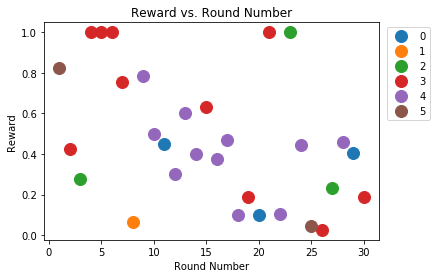

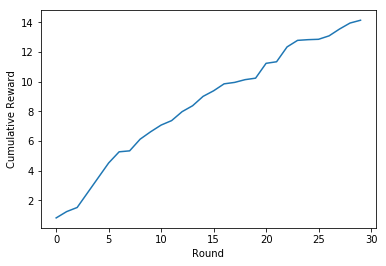

In [64]:
s1, r1 = thompson_sampling(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s1, r1)

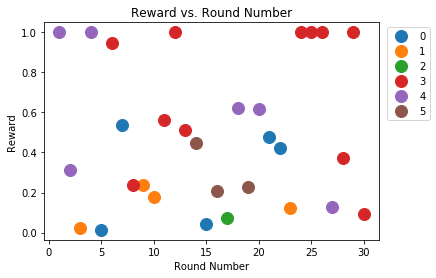

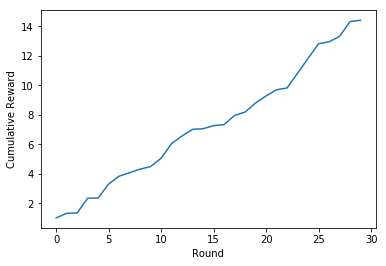

In [12]:
budget = 10
s2, r2 = thompson_sampling_with_budget(num_arms, num_episodes, budget, _beta)
singleGraph(num_arms, num_episodes, s2, r2)

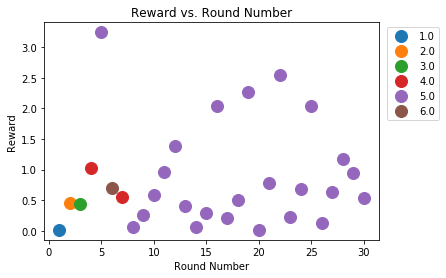

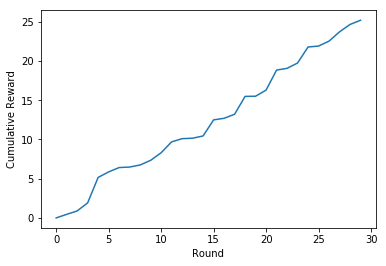

In [13]:
epsilon = 0.25
s3, r3 = peef(num_arms, num_episodes, epsilon, _beta)
singleGraph(num_arms, num_episodes, s3, r3)

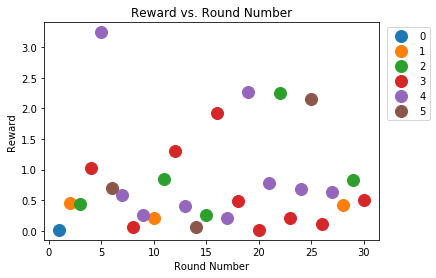

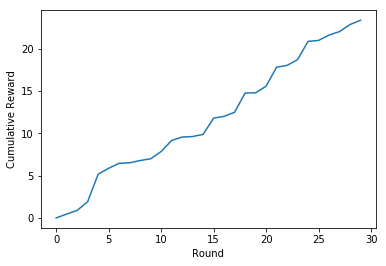

In [14]:
factor = 0.4
s4, r4 = SOAAv(num_arms, num_episodes, factor, _beta)
singleGraph(num_arms, num_episodes, s4, r4)

4
3
1


C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


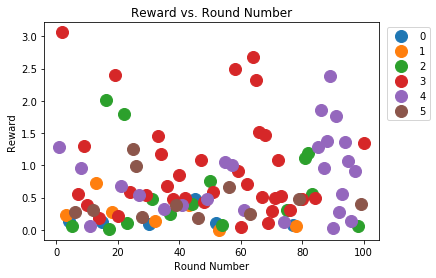

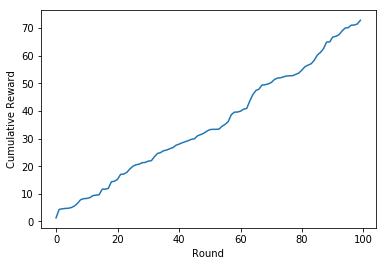

In [33]:
s5, r5 = UCB_algorithm(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s5, r5)

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


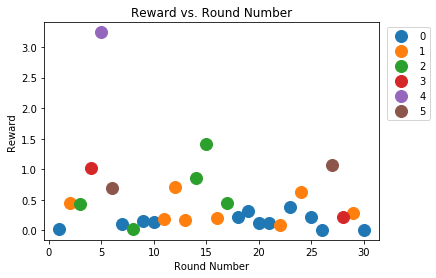

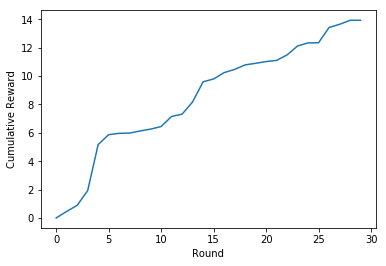

In [113]:
s6, r6 = ExpTS(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s6, r6)

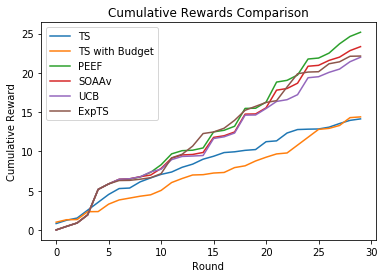

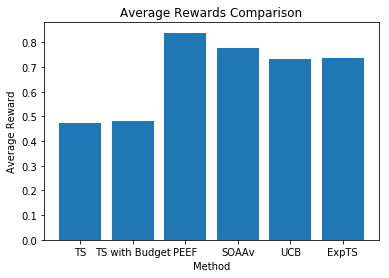

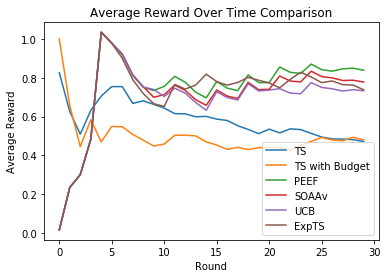

In [17]:
multiGraph(num_arms, num_episodes, budget, epsilon, factor, _beta)

In [47]:
num_arms = 6
num_episodes = 500
num_runs = 500
betas = [[0.2, 0.3, 0.75, 0.8, 0.85, 0.9],  
         [0.2, 0.3, 0.75, 0.8, 0.85, 0.9],  
         [0.75, 0.8, 0.85, 0.9, 0.2, 0.3]]

['82.6', '42.6', '27.7', '100.0', '100.0', '100.0', '75.2', '6.4', '78.6', '50.0', '45.1', '30.1', '60.3', '39.8', '63.2', '37.5', '46.9', '9.7', '18.5', '10.1', '100.0', '10.6', '100.0', '44.2', '4.7', '2.6', '23.1', '46.1', '40.3', '18.8', '86.0', '95.2', '100.0']
['0.8', '0.4', '0.3', '1.0', '1.0', '1.0', '0.8', '0.1', '0.8', '0.5', '0.5', '0.3', '0.6', '0.4', '0.6', '0.4', '0.5', '0.1', '0.2', '0.1', '1.0', '0.1', '1.0', '0.4', '0.0', '0.0', '0.2', '0.5', '0.4', '0.2', '0.9', '1.0', '1.0']
Total rewards:1696.16
Avg rewards:16.96


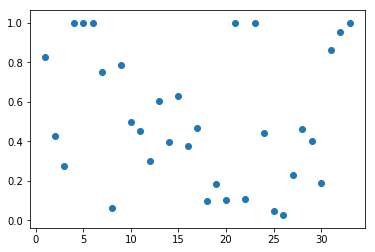

['82.6', '32.0', '16.6', '95.6', '100.0', '99.0', '56.4', '6.4', '69.4', '44.1', '12.2', '21.2', '21.8', '21.1', '81.0', '38.3', '34.5', '100.0', '41.2', '42.1', '69.4', '28.0', '100.0', '8.5', '0.9', '100.0', '71.6', '100.0', '21.5', '13.5', '12.9', '83.6', '100.0']
['0.8', '0.3', '0.2', '1.0', '1.0', '1.0', '0.6', '0.1', '0.7', '0.4', '0.1', '0.2', '0.2', '0.2', '0.8', '0.4', '0.3', '1.0', '0.4', '0.4', '0.7', '0.3', '1.0', '0.1', '0.0', '1.0', '0.7', '1.0', '0.2', '0.1', '0.1', '0.8', '1.0']
Total rewards:1725.47
Avg rewards:17.25


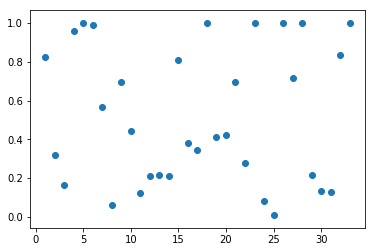

['27.5', '47.9', '100.0', '100.0', '27.5', '100.0', '100.0', '100.0', '18.5', '100.0', '67.7', '44.2', '100.0', '24.4', '32.1', '33.1', '9.6', '100.0', '8.7', '25.3', '100.0', '36.4', '100.0', '13.2', '13.1', '100.0', '23.6', '100.0', '55.0', '29.6', '80.4', '83.7', '4.5']
['0.3', '0.5', '1.0', '1.0', '0.3', '1.0', '1.0', '1.0', '0.2', '1.0', '0.7', '0.4', '1.0', '0.2', '0.3', '0.3', '0.1', '1.0', '0.1', '0.3', '1.0', '0.4', '1.0', '0.1', '0.1', '1.0', '0.2', '1.0', '0.6', '0.3', '0.8', '0.8', '0.0']
Total rewards:1906.14
Avg rewards:19.06


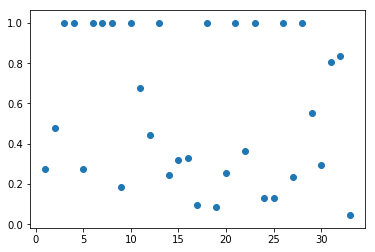

['82.6', '42.6', '27.7', '100.0', '100.0', '100.0', '75.2', '15.0', '78.6', '50.0', '100.0', '30.1', '60.3', '100.0', '2.6', '52.4', '81.0', '100.0', '66.3', '56.9', '58.0', '57.1', '84.7', '27.8', '21.7', '2.7', '100.0', '11.5', '100.0', '60.0', '57.6', '46.0', '75.0']
['0.8', '0.4', '0.3', '1.0', '1.0', '1.0', '0.8', '0.1', '0.8', '0.5', '1.0', '0.3', '0.6', '1.0', '0.0', '0.5', '0.8', '1.0', '0.7', '0.6', '0.6', '0.6', '0.8', '0.3', '0.2', '0.0', '1.0', '0.1', '1.0', '0.6', '0.6', '0.5', '0.8']
Total rewards:2023.47
Avg rewards:20.23


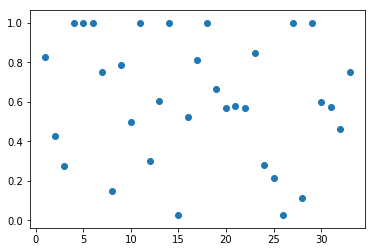

In [18]:
ts_t_e = []
ts_a_e = []
ts_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = thompson_sampling(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ts_t_e.append(total_rewards_per_episode)
    ts_a_e.append(average_rewards_per_episode)
    ts_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['100.0', '31.3', '2.2', '100.0', '1.4', '94.7', '2.6', '65.2', '100.0', '100.0', '79.2', '100.0', '100.0', '95.8', '25.3', '100.0', '100.0', '100.0', '58.4', '100.0', '30.5', '100.0', '86.8', '17.5', '100.0', '16.9', '100.0', '97.2', '35.3', '26.7', '21.9', '89.3', '100.0']
['1.0', '0.3', '0.0', '1.0', '0.0', '0.9', '0.0', '0.7', '1.0', '1.0', '0.8', '1.0', '1.0', '1.0', '0.3', '1.0', '1.0', '1.0', '0.6', '1.0', '0.3', '1.0', '0.9', '0.2', '1.0', '0.2', '1.0', '1.0', '0.4', '0.3', '0.2', '0.9', '1.0']
Total rewards:2278.36
Avg rewards:22.78


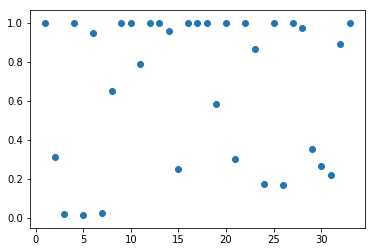

['100.0', '27.6', '2.2', '100.0', '1.0', '71.1', '2.6', '48.9', '96.3', '100.0', '29.8', '88.3', '100.0', '68.3', '60.1', '49.7', '100.0', '37.5', '49.0', '61.3', '73.3', '23.5', '22.6', '5.6', '100.0', '66.0', '26.2', '45.4', '24.5', '9.3', '53.1', '44.4', '8.6']
['1.0', '0.3', '0.0', '1.0', '0.0', '0.7', '0.0', '0.5', '1.0', '1.0', '0.3', '0.9', '1.0', '0.7', '0.6', '0.5', '1.0', '0.4', '0.5', '0.6', '0.7', '0.2', '0.2', '0.1', '1.0', '0.7', '0.3', '0.5', '0.2', '0.1', '0.5', '0.4', '0.1']
Total rewards:1696.23
Avg rewards:16.96


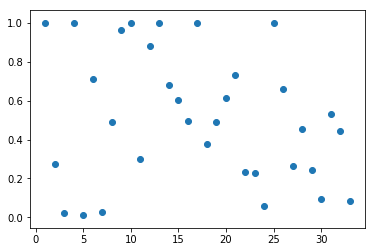

['30.3', '7.4', '6.0', '40.6', '5.1', '100.0', '47.3', '73.4', '22.6', '1.5', '22.6', '100.0', '46.8', '44.4', '71.3', '70.3', '14.9', '1.7', '100.0', '86.9', '59.7', '18.6', '5.4', '100.0', '5.6', '67.6', '65.1', '100.0', '84.8', '100.0', '65.0', '100.0', '100.0']
['0.3', '0.1', '0.1', '0.4', '0.1', '1.0', '0.5', '0.7', '0.2', '0.0', '0.2', '1.0', '0.5', '0.4', '0.7', '0.7', '0.1', '0.0', '1.0', '0.9', '0.6', '0.2', '0.1', '1.0', '0.1', '0.7', '0.7', '1.0', '0.8', '1.0', '0.7', '1.0', '1.0']
Total rewards:1764.95
Avg rewards:17.65


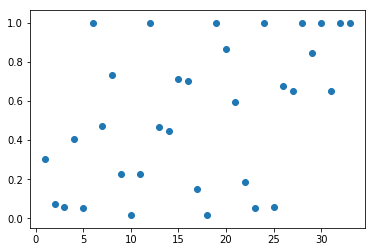

['100.0', '31.3', '5.2', '100.0', '4.4', '94.7', '6.1', '65.2', '100.0', '100.0', '79.2', '100.0', '100.0', '95.8', '25.3', '100.0', '100.0', '100.0', '58.4', '100.0', '30.5', '100.0', '86.8', '17.5', '100.0', '16.9', '100.0', '97.2', '35.3', '26.7', '21.9', '89.3', '100.0']
['1.0', '0.3', '0.1', '1.0', '0.0', '0.9', '0.1', '0.7', '1.0', '1.0', '0.8', '1.0', '1.0', '1.0', '0.3', '1.0', '1.0', '1.0', '0.6', '1.0', '0.3', '1.0', '0.9', '0.2', '1.0', '0.2', '1.0', '1.0', '0.4', '0.3', '0.2', '0.9', '1.0']
Total rewards:2287.91
Avg rewards:22.88


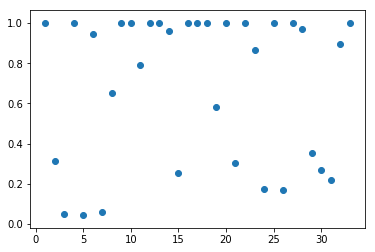

In [19]:
budget = 6
tsb_t_e = []
tsb_a_e = []
tsb_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = thompson_sampling_with_budget(num_arms, num_episodes, budget, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    tsb_t_e.append(total_rewards_per_episode)
    tsb_a_e.append(average_rewards_per_episode)
    tsb_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '20.9', '5.6', '25.0', '58.9', '102.3', '48.8', '38.4', '5.8', '30.6', '192.3', '20.4', '54.2', '214.1', '2.1', '82.6', '239.9', '22.2', '63.6', '203.9', '11.4', '63.0', '111.0', '88.5', '50.5', '18.3', '54.0', '37.3', '51.9', '38.7', '145.6', '117.1', '30.1', '68.0', '25.8', '48.2', '34.8', '91.1', '39.3', '49.2', '108.0', '45.3', '189.5', '15.9', '108.1', '43.9', '44.5', '80.5', '59.2', '45.6', '0.1', '8.2', '98.9', '59.4', '95.3', '248.9', '91.9', '4.4', '29.6', '71.8', '21.4', '268.1', '232.1', '150.9', '51.1', '147.3', '11.2', '29.5', '49.7', '108.3', '53.2', '11.8', '33.7', '31.4', '28.6', '14.5', '42.9', '47.6', '119.3', '127.3', '59.1', '49.4', '120.5', '174.6', '89.9', '128.9', '223.9', '3.3', '166.8', '25.9', '51.7', '127.5', '101.1', '12.7', '86.0']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.2', '0.1', '0.3', '0.6', '1.0', '0.5', '0.4', '0.1', '0.3', '1.9', '0.2', '0.5', '2.1', '0.0', '0.8', '2.4', '0.2', '0.6', '2.0', '0.

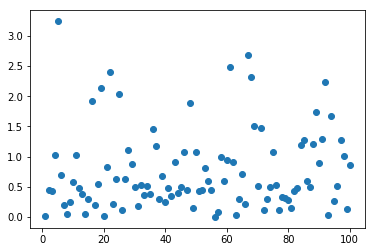

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '20.9', '5.6', '25.0', '58.9', '102.3', '48.8', '38.4', '5.8', '30.6', '192.3', '20.4', '54.2', '214.1', '2.1', '82.6', '239.9', '22.2', '63.6', '203.9', '11.4', '63.0', '111.0', '88.5', '50.5', '18.3', '54.0', '37.3', '51.9', '38.7', '145.6', '117.1', '30.1', '68.0', '25.8', '48.2', '34.8', '91.1', '39.3', '49.2', '108.0', '45.3', '189.5', '15.9', '108.1', '43.9', '44.5', '80.5', '59.2', '45.6', '0.1', '8.2', '98.9', '59.4', '95.3', '248.9', '91.9', '4.4', '29.6', '71.8', '21.4', '268.1', '232.1', '150.9', '51.1', '147.3', '11.2', '29.5', '49.7', '108.3', '53.2', '11.8', '33.7', '31.4', '28.6', '14.5', '42.9', '47.6', '119.3', '127.3', '59.1', '49.4', '120.5', '174.6', '89.9', '128.9', '223.9', '3.3', '166.8', '25.9', '51.7', '127.5', '101.1', '12.7', '86.0']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.2', '0.1', '0.3', '0.6', '1.0', '0.5', '0.4', '0.1', '0.3', '1.9', '0.2', '0.5', '2.1', '0.0', '0.8', '2.4', '0.2', '0.6', '2.0', '0.

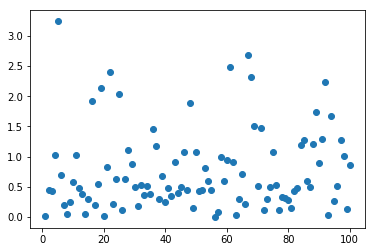

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '55.6', '6.4', '28.1', '13.9', '34.1', '130.3', '43.2', '1.4', '10.2', '192.3', '21.6', '12.0', '214.1', '2.1', '82.6', '239.9', '23.6', '63.6', '215.8', '11.4', '66.7', '111.0', '88.5', '50.5', '18.3', '54.0', '37.3', '51.9', '36.4', '145.6', '117.1', '30.1', '68.0', '25.8', '48.2', '34.8', '85.7', '37.0', '49.2', '101.6', '42.6', '189.5', '15.9', '108.1', '43.9', '44.5', '80.5', '59.2', '42.9', '0.1', '7.7', '98.9', '59.4', '95.3', '248.9', '91.9', '4.4', '29.6', '71.8', '21.4', '268.1', '232.1', '150.9', '51.1', '147.3', '11.2', '29.5', '49.7', '108.3', '53.2', '11.8', '33.7', '31.4', '28.6', '14.5', '42.9', '47.6', '119.3', '127.3', '59.1', '49.4', '120.5', '174.6', '89.9', '128.9', '223.9', '3.3', '166.8', '25.9', '51.7', '127.5', '101.1', '12.7', '86.0']
['0.1', '1.2', '0.5', '1.2', '0.8', '0.2', '0.6', '0.1', '0.3', '0.1', '0.3', '1.3', '0.4', '0.0', '0.1', '1.9', '0.2', '0.1', '2.1', '0.0', '0.8', '2.4', '0.2', '0.6', '2.2', '0.

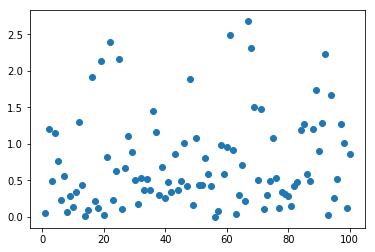

In [15]:
epsilon = 0.25
peef_t_e = []
peef_a_e = []
peef_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = peef(num_arms, num_episodes, epsilon, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    peef_t_e.append(total_rewards_per_episode)
    peef_a_e.append(average_rewards_per_episode)
    peef_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '59.1', '6.0', '26.6', '62.4', '34.1', '122.1', '38.4', '5.8', '30.6', '72.1', '18.0', '48.1', '227.5', '2.3', '27.5', '224.9', '20.9', '67.6', '215.8', '10.7', '59.3', '118.0', '99.5', '18.9', '17.2', '54.0', '39.6', '58.4', '13.7', '136.5', '117.1', '32.0', '76.5', '9.7', '45.2', '34.8', '91.1', '41.6', '18.4', '95.3', '42.6', '201.4', '17.9', '40.5', '41.2', '44.5', '85.5', '66.6', '16.1', '0.1', '7.7', '105.0', '66.9', '35.7', '233.4', '91.9', '4.6', '33.2', '26.9', '20.1', '268.1', '246.6', '169.8', '47.9', '147.3', '11.9', '33.2', '18.7', '101.6', '53.2', '12.5', '37.9', '11.8', '26.8', '14.5', '45.6', '53.5', '44.7', '119.4', '59.1', '52.5', '135.5', '65.5', '84.3', '128.9', '237.9', '3.7', '62.5', '24.3', '51.7', '135.4', '113.7', '4.8', '80.6']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.3', '0.6', '0.3', '1.2', '0.4', '0.1', '0.3', '0.7', '0.2', '0.5', '2.3', '0.0', '0.3', '2.2', '0.2', '0.7', '2.2', '0.1', '0.

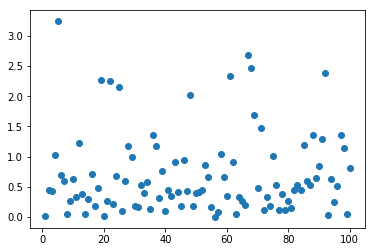

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '59.1', '6.0', '26.6', '62.4', '34.1', '122.1', '38.4', '5.8', '30.6', '72.1', '18.0', '48.1', '227.5', '2.3', '27.5', '224.9', '20.9', '67.6', '215.8', '10.7', '59.3', '118.0', '99.5', '18.9', '17.2', '54.0', '39.6', '58.4', '13.7', '136.5', '117.1', '32.0', '76.5', '9.7', '45.2', '34.8', '91.1', '41.6', '18.4', '95.3', '42.6', '201.4', '17.9', '40.5', '41.2', '44.5', '85.5', '66.6', '16.1', '0.1', '7.7', '105.0', '66.9', '35.7', '233.4', '91.9', '4.6', '33.2', '26.9', '20.1', '268.1', '246.6', '169.8', '47.9', '147.3', '11.9', '33.2', '18.7', '101.6', '53.2', '12.5', '37.9', '11.8', '26.8', '14.5', '45.6', '53.5', '44.7', '119.4', '59.1', '52.5', '135.5', '65.5', '84.3', '128.9', '237.9', '3.7', '62.5', '24.3', '51.7', '135.4', '113.7', '4.8', '80.6']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.3', '0.6', '0.3', '1.2', '0.4', '0.1', '0.3', '0.7', '0.2', '0.5', '2.3', '0.0', '0.3', '2.2', '0.2', '0.7', '2.2', '0.1', '0.

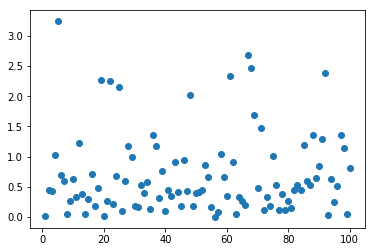

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '55.6', '6.7', '6.3', '55.4', '96.6', '146.5', '9.6', '5.5', '28.9', '216.3', '19.2', '51.1', '240.9', '2.0', '78.0', '269.8', '20.9', '67.6', '215.8', '11.4', '63.0', '124.9', '88.5', '53.6', '20.6', '13.5', '37.3', '55.2', '41.0', '36.4', '117.1', '32.0', '76.5', '6.5', '48.2', '37.0', '96.4', '9.3', '49.2', '108.0', '47.9', '47.4', '15.9', '114.9', '49.4', '11.1', '80.5', '62.9', '48.2', '0.0', '7.7', '105.0', '66.9', '23.8', '248.9', '97.6', '4.9', '7.4', '71.8', '22.8', '301.6', '58.0', '150.9', '54.3', '165.8', '11.2', '31.4', '56.0', '108.3', '56.5', '13.2', '8.4', '31.4', '30.4', '16.3', '10.7', '47.6', '126.8', '143.2', '14.8', '49.4', '128.0', '196.5', '22.5', '128.9', '237.9', '3.7', '41.7', '25.9', '54.9', '143.4', '101.1', '13.5', '96.8']
['0.1', '1.2', '0.5', '1.2', '0.8', '0.2', '0.6', '0.1', '0.1', '0.6', '1.0', '1.5', '0.1', '0.1', '0.3', '2.2', '0.2', '0.5', '2.4', '0.0', '0.8', '2.7', '0.2', '0.7', '2.2', '0.1', '0.6'

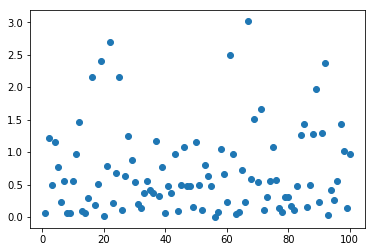

In [16]:
factor = 0.14
soaav_t_e = []
soaav_a_e = []
soaav_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = SOAAv(num_arms, num_episodes, factor, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    soaav_t_e.append(total_rewards_per_episode)
    soaav_a_e.append(average_rewards_per_episode)
    soaav_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '59.1', '6.4', '25.0', '62.4', '34.1', '122.1', '40.8', '5.1', '6.8', '216.3', '21.6', '48.1', '227.5', '2.1', '82.6', '89.9', '22.2', '63.6', '215.8', '12.9', '55.6', '41.6', '94.0', '56.8', '18.3', '57.4', '9.3', '48.7', '41.0', '54.6', '124.4', '32.0', '76.5', '24.2', '18.1', '34.8', '91.1', '41.6', '52.2', '25.4', '47.9', '201.4', '16.9', '101.4', '43.9', '41.7', '85.5', '22.2', '45.6', '0.1', '8.2', '92.7', '59.4', '89.3', '62.2', '86.1', '4.9', '11.1', '67.3', '21.4', '284.9', '246.6', '160.4', '54.3', '156.6', '11.9', '31.4', '52.8', '115.1', '56.5', '2.9', '35.8', '29.4', '30.4', '16.3', '42.9', '50.5', '44.7', '119.4', '55.4', '52.5', '113.0', '163.7', '84.3', '120.9', '209.9', '3.1', '156.4', '24.3', '48.4', '143.4', '113.7', '14.3', '91.4', '5.7', '8.8', '50.3', '47.4', '68.7', '117.2', '154.9', '128.6', '0.6', '40.9', '52.9', '5.1', '23.4', '79.6', '132.2', '213.3', '10.3', '19.6', '91.5', '12.1', '19.0', '77.0', '14.9', '13

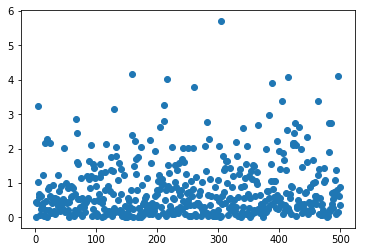

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '59.1', '6.4', '25.0', '62.4', '34.1', '122.1', '40.8', '5.1', '6.8', '216.3', '21.6', '48.1', '227.5', '2.1', '82.6', '89.9', '22.2', '63.6', '215.8', '12.9', '55.6', '41.6', '94.0', '56.8', '18.3', '57.4', '9.3', '48.7', '41.0', '54.6', '124.4', '32.0', '76.5', '24.2', '18.1', '34.8', '91.1', '41.6', '52.2', '25.4', '47.9', '201.4', '16.9', '101.4', '43.9', '41.7', '85.5', '22.2', '45.6', '0.1', '8.2', '92.7', '59.4', '89.3', '62.2', '86.1', '4.9', '11.1', '67.3', '21.4', '284.9', '246.6', '160.4', '54.3', '156.6', '11.9', '31.4', '52.8', '115.1', '56.5', '2.9', '35.8', '29.4', '30.4', '16.3', '42.9', '50.5', '44.7', '119.4', '55.4', '52.5', '113.0', '163.7', '84.3', '120.9', '209.9', '3.1', '156.4', '24.3', '48.4', '143.4', '113.7', '14.3', '91.4', '5.7', '8.8', '50.3', '47.4', '68.7', '117.2', '154.9', '128.6', '0.6', '40.9', '52.9', '5.1', '23.4', '79.6', '132.2', '213.3', '10.3', '19.6', '91.5', '12.1', '19.0', '77.0', '14.9', '13

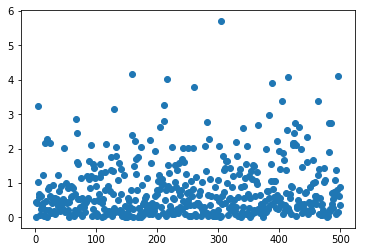

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '55.6', '6.7', '6.3', '58.9', '91.0', '48.8', '36.0', '6.1', '27.2', '204.3', '20.4', '12.0', '80.3', '2.1', '73.4', '224.9', '19.6', '59.6', '71.9', '12.9', '59.3', '41.6', '82.9', '53.6', '4.6', '50.6', '37.3', '55.2', '13.7', '136.5', '109.8', '28.3', '76.5', '25.8', '51.3', '39.2', '80.3', '9.3', '52.2', '38.1', '40.0', '189.5', '15.9', '108.1', '43.9', '50.0', '85.5', '55.5', '45.6', '0.1', '2.9', '111.2', '66.9', '89.3', '62.2', '103.4', '4.9', '27.7', '76.3', '5.4', '284.9', '246.6', '160.4', '54.3', '156.6', '11.9', '31.4', '52.8', '115.1', '56.5', '12.5', '33.7', '29.4', '30.4', '5.4', '48.2', '50.5', '119.3', '127.3', '59.1', '49.4', '113.0', '163.7', '84.3', '120.9', '209.9', '3.1', '156.4', '24.3', '48.4', '135.4', '107.4', '13.5', '96.8', '6.5', '33.1', '134.1', '44.6', '18.3', '104.2', '137.7', '114.3', '0.6', '46.3', '18.7', '4.3', '66.3', '74.9', '149.8', '241.7', '11.7', '22.3', '96.9', '12.8', '21.6', '68.4', '13.9', '

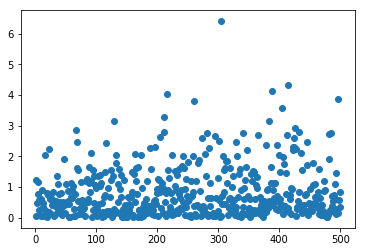

In [48]:
ucb_t_e = []
ucb_a_e = []
ucb_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = UCB_algorithm(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ucb_t_e.append(total_rewards_per_episode)
    ucb_a_e.append(average_rewards_per_episode)
    ucb_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


['128.7', '306.2', '23.2', '13.9', '5.6', '28.1', '55.4', '96.6', '130.3', '38.4', '5.8', '30.6', '72.1', '19.2', '12.0', '200.7', '1.9', '27.5', '239.9', '20.9', '67.6', '179.9', '10.7', '59.3', '124.9', '99.5', '53.6', '20.6', '54.0', '9.3', '48.7', '13.7', '145.6', '117.1', '32.0', '68.0', '24.2', '48.2', '39.2', '85.7', '39.3', '49.2', '38.1', '40.0', '47.4', '17.9', '108.1', '43.9', '47.3', '75.5', '59.2', '10.7', '0.0', '7.3', '105.0', '66.9', '101.3', '248.9', '91.9', '4.4', '31.4', '71.8', '24.1', '268.1', '232.1', '150.9', '51.1', '147.3', '11.2', '29.5', '49.7', '108.3', '53.2', '12.5', '31.6', '31.4', '7.1', '5.4', '48.2', '47.6', '111.8', '119.4', '55.4', '49.4', '128.0', '185.5', '95.5', '137.0', '237.9', '3.5', '177.2', '27.5', '54.9', '135.4', '107.4', '13.5', '91.4', '5.4', '39.8', '134.1', '44.6', '77.9', '110.7', '146.3', '121.5', '0.6', '43.6', '49.8', '1.1', '66.3', '28.1', '158.7', '256.0', '12.3', '23.6', '96.9', '12.8', '19.0', '68.4', '15.8', '121.9', '155.6', '

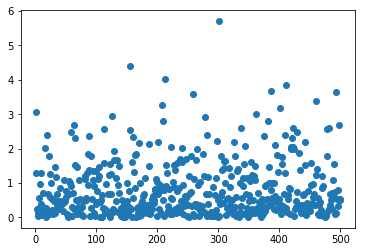

['128.7', '306.2', '23.2', '13.9', '5.6', '28.1', '55.4', '96.6', '130.3', '38.4', '5.8', '30.6', '72.1', '19.2', '12.0', '200.7', '1.9', '27.5', '239.9', '20.9', '67.6', '179.9', '10.7', '59.3', '124.9', '99.5', '53.6', '20.6', '54.0', '9.3', '48.7', '13.7', '145.6', '117.1', '32.0', '68.0', '24.2', '48.2', '39.2', '85.7', '39.3', '49.2', '38.1', '40.0', '47.4', '17.9', '108.1', '43.9', '47.3', '75.5', '59.2', '10.7', '0.0', '7.3', '105.0', '66.9', '101.3', '248.9', '91.9', '4.4', '31.4', '71.8', '24.1', '268.1', '232.1', '150.9', '51.1', '147.3', '11.2', '29.5', '49.7', '108.3', '53.2', '12.5', '31.6', '31.4', '7.1', '5.4', '48.2', '47.6', '111.8', '119.4', '55.4', '49.4', '128.0', '185.5', '95.5', '137.0', '237.9', '3.5', '177.2', '27.5', '54.9', '135.4', '107.4', '13.5', '91.4', '5.4', '39.8', '134.1', '44.6', '77.9', '110.7', '146.3', '121.5', '0.6', '43.6', '49.8', '1.1', '66.3', '28.1', '158.7', '256.0', '12.3', '23.6', '96.9', '12.8', '19.0', '68.4', '15.8', '121.9', '155.6', '

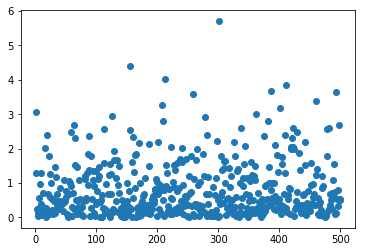

['30.3', '344.4', '61.9', '52.2', '6.4', '9.4', '62.4', '102.3', '146.5', '38.4', '5.1', '30.6', '48.1', '7.2', '51.1', '240.9', '2.3', '82.6', '239.9', '20.9', '15.9', '191.9', '11.4', '66.7', '118.0', '82.9', '53.6', '20.6', '54.0', '34.9', '19.5', '41.0', '154.7', '124.4', '32.0', '68.0', '6.5', '54.3', '34.8', '91.1', '34.7', '55.3', '108.0', '45.3', '213.2', '17.9', '108.1', '16.5', '44.5', '90.6', '66.6', '40.2', '0.1', '1.9', '111.2', '59.4', '107.2', '280.0', '103.4', '4.9', '33.2', '71.8', '20.1', '301.6', '261.1', '169.8', '57.5', '165.8', '12.6', '33.2', '56.0', '121.9', '20.0', '13.2', '35.8', '31.4', '32.2', '15.4', '48.2', '47.6', '29.8', '143.2', '66.5', '46.3', '135.5', '196.5', '101.1', '145.1', '251.9', '3.7', '187.6', '29.1', '58.1', '143.4', '113.7', '14.3', '86.0', '2.2', '35.3', '142.4', '47.4', '82.4', '117.2', '129.1', '107.2', '0.5', '49.1', '52.9', '1.1', '70.2', '74.9', '158.7', '256.0', '12.3', '23.6', '91.5', '12.8', '20.3', '72.7', '13.9', '137.2', '175.0'

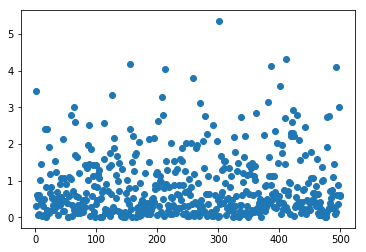

In [49]:
ucb_t_e0 = []
ucb_a_e0 = []
ucb_t0 = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = UCB_algorithm0(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ucb_t_e0.append(total_rewards_per_episode)
    ucb_a_e0.append(average_rewards_per_episode)
    ucb_t0.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 3.243800780025824, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.8257112271444202, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.224284914236809, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.0756983093457781, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 0.9708786405485821, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.7553751604694088, 0.9708786405485821, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.7553751604694088, 1.144670117007167, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.7553751604694088, 1.0462252804030263, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.432736398

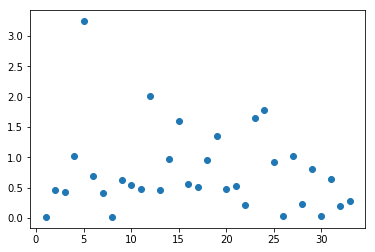

[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 2.8621771588463156, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 1.6109216710097827, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 1.0802513949148318, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 0.9491455670698042, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 0.8566576240134548, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 0.7892587751386345, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 0.9303261138961519, 0.69593784920057]
[0.011906536428216676, 0.454127602367636, 0.2596418388704321, 0.7712511160924864, 0.864280525480256, 0.69593784920057]
[0.011906536428216676, 0.454127602367636,

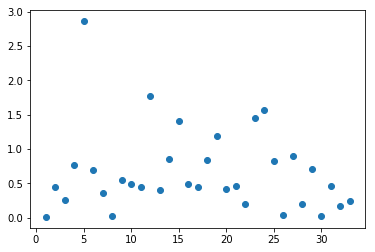

[0.059532682141083385, 1.2110069396470295, 0.4904345845330384, 1.1568766741387297, 0.7632472423590175, 0.23197928306685664]
[0.059532682141083385, 0.7973254341825812, 0.4904345845330384, 1.1568766741387297, 0.7632472423590175, 0.23197928306685664]
[0.059532682141083385, 0.7973254341825812, 0.4904345845330384, 0.5897848427043226, 0.7632472423590175, 0.23197928306685664]
[0.059532682141083385, 0.729178052489622, 0.4904345845330384, 0.5897848427043226, 0.7632472423590175, 0.23197928306685664]
[0.059532682141083385, 0.729178052489622, 0.4904345845330384, 0.5897848427043226, 0.4465177347512497, 0.23197928306685664]
[0.059532682141083385, 0.6674874142377587, 0.4904345845330384, 0.5897848427043226, 0.4465177347512497, 0.23197928306685664]
[0.059532682141083385, 0.9130256959643417, 0.4904345845330384, 0.5897848427043226, 0.4465177347512497, 0.23197928306685664]
[0.059532682141083385, 0.8323145522492154, 0.4904345845330384, 0.5897848427043226, 0.4465177347512497, 0.23197928306685664]
[0.0595326

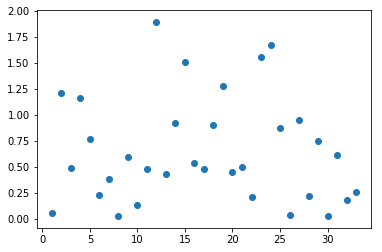

[0.051594991188938934, 1.0596310721911506, 0.43273639811738684, 1.0283348214566486, 3.243800780025824, 0.69593784920057]
[0.051594991188938934, 1.0596310721911506, 0.43273639811738684, 1.0283348214566486, 1.8257112271444202, 0.69593784920057]
[0.051594991188938934, 1.0596310721911506, 0.43273639811738684, 1.0283348214566486, 1.224284914236809, 0.69593784920057]
[0.051594991188938934, 1.0596310721911506, 0.43273639811738684, 1.0283348214566486, 1.0756983093457781, 0.69593784920057]
[0.051594991188938934, 1.0596310721911506, 0.43273639811738684, 1.0283348214566486, 0.9708786405485821, 0.69593784920057]
[0.051594991188938934, 0.7408723171190242, 0.43273639811738684, 1.0283348214566486, 0.9708786405485821, 0.69593784920057]
[0.051594991188938934, 0.7408723171190242, 0.43273639811738684, 1.461756822163661, 0.9708786405485821, 0.69593784920057]
[0.051594991188938934, 0.7408723171190242, 0.43273639811738684, 1.1174241593336351, 0.9708786405485821, 0.69593784920057]
[0.051594991188938934, 0.74

KeyboardInterrupt: 

In [58]:
ets_t_e = []
ets_a_e = []
ets_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = exponential_thompson_sampling(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ets_t_e.append(total_rewards_per_episode)
    ets_a_e.append(average_rewards_per_episode)
    ets_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

In [18]:
ts_a, tsb_a, peef_a, soaav_a, ucb_a, ets_a = [],[],[],[],[],[]
for i in range(3): 
    #ts_a.append(np.sum(ts_a_e[i]))
    #tsb_a.append(np.sum(tsb_a_e[i]))
    peef_a.append(np.sum(peef_a_e[i]))
    soaav_a.append(np.sum(soaav_a_e[i]))
    ucb_a.append(np.sum(ucb_a_e[i]))
    #ets_a.append(np.sum(ets_a_e[i]))
print("Average Rewards over 3 sets of Beta values:")
#print("TS")
#print(ts_a)
#print("TS with budget")
#print(tsb_a)
print("peef")
print(peef_a)
print("SOAAv")
print(soaav_a)
print("UCB")
print(ucb_a)
#print("ExpTS")
#print(ets_a)

Average Rewards over 3 sets of Beta values:
peef
[76.42906770522306, 76.42906770522306, 73.87859403992432]
SOAAv
[69.7189907250373, 69.7189907250373, 69.26093818663702]
UCB
[69.96258309587841, 69.96258309587841, 67.52744014866639]


In [ ]:
n_betas = len(betas)
bar_width = 0.12

x = np.arange(n_betas)

plt.figure(figsize=(12, 6))
plt.bar(x - 2*bar_width, ts_a, width=bar_width, label='TS')
plt.bar(x - bar_width, tsb_a, width=bar_width, label='TS with budget')
plt.bar(x, peef_a, width=bar_width, label='PEEF')
plt.bar(x + bar_width, soaav_a, width=bar_width, label='SOAAv')
plt.bar(x + 2*bar_width, ucb_a, width=bar_width, label='UCB')
plt.bar(x + 3*bar_width, ets_a, width=bar_width, label='ExpTS')

# Adding labels and title
plt.xlabel('Beta Values')
plt.ylabel('Average Rewards')
plt.title('Average Rewards over 4 sets of Beta values')
plt.xticks(x, betas)
plt.legend()
plt.show()

In [ ]:
for i in range(4):
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Plot the total rewards for each method
    plt.scatter(np.arange(1, num_episodes+1), ts_a_e[i], label='TS')
    plt.scatter(np.arange(1, num_episodes+1), tsb_a_e[i], label='TS with budget')
    plt.scatter(np.arange(1, num_episodes+1), peef_a_e[i], label='PEEF')
    plt.scatter(np.arange(1, num_episodes+1), soaav_a_e[i], label='SOAAv')
    plt.scatter(np.arange(1, num_episodes+1), ucb_a_e[i], label='UCB')
    plt.scatter(np.arange(1, num_episodes+1), ets_a_e[i], label='ExpTS')
    
    # Adding labels and title
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Average Rewards over Episodes - Beta {i+1}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for i in range(4):
    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Cumulative rewards comparison
    plt.subplot(2, 2, 1)
    plt.plot(np.cumsum(ts_t_e[i]), label='TS')
    plt.plot(np.cumsum(tsb_t_e[i]), label='TS with budget')
    plt.plot(np.cumsum(peef_t_e[i]), label='PEEF')
    plt.plot(np.cumsum(soaav_t_e[i]), label='SOAAv')
    plt.plot(np.cumsum(ucb_t_e[i]), label='UCB')
    plt.plot(np.cumsum(ets_t_e[i]), label='ExpTS')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Rewards Comparison - Beta {i+1}')
    plt.legend()

    # Average reward
    plt.subplot(2, 2, 2)
    avg_rewards = [np.mean(ts_t_e[i]), np.mean(tsb_t_e[i]), np.mean(peef_t_e[i]), np.mean(soaav_t_e[i]), np.mean(ucb_t_e[i]), np.mean(ets_t_e[i])]
    methods = ['TS', 'TS with Budget', 'PEEF', 'SOAAv', 'UCB', 'ExpTS']
    plt.bar(methods, avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Average Reward over Time - Beta {i+1}')
    
    # Average reward over time plot
    plt.subplot(2, 2, 3)
    average_reward_over_time_1 = np.cumsum(ts_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_2 = np.cumsum(tsb_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_3 = np.cumsum(peef_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_4 = np.cumsum(soaav_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_5 = np.cumsum(ucb_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_6 = np.cumsum(ets_t_e[i]) / np.arange(1, num_episodes+1)

    plt.plot(average_reward_over_time_1, label='TS')
    plt.plot(average_reward_over_time_2, label='TS with Budget')
    plt.plot(average_reward_over_time_3, label='PEEF')
    plt.plot(average_reward_over_time_4, label='SOAAv')
    plt.plot(average_reward_over_time_5, label='UCB')
    plt.plot(average_reward_over_time_6, label='ExpTS')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time Comparison')
    plt.legend()
    

    # Adding space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()